In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant, calc_Sqw_from_SpinW_results
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

In [3]:
cmap_mako = sns.color_palette("mako", as_cmap=True)

In [4]:
from inxss.experiment import SimulatedExperiment, NeutronExperiment

In [5]:
incident_energy = 260

In [6]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')
Sqw = torch.from_numpy(calc_Sqw_from_SpinW_results(q_grid, Syy, Szz))

In [7]:
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering/experiment_data/summarized_neutron_data_{incident_energy:d}meV.pt')

neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)

hklw_grid_norm = hklw_grid[...,:2].norm(dim=-1)
neutron_exp.prepare_experiment(hklw_grid)

In [8]:
sim_exp = SimulatedExperiment(q_grid, w_grid, Syy, Szz, neutron_flux=3e2)

In [9]:
s_pred = sim_exp.get_measurements_on_coords(hklw_grid).numpy()

In [10]:
# pearson_cc_sigma = []
_sigma = 1.25
s_pred_sm = gaussian_filter(s_pred, sigma=_sigma)
mask_exp = neutron_exp.Sqw > 1e-10
mask_pred = (s_pred_sm > 5e-2*s_pred_sm.max()) * mask_exp.cpu().numpy()
s_pred_masked = s_pred * mask_pred
s_pred_masked_sm = s_pred_sm * mask_pred

In [18]:
total_signal = neutron_exp.Sqw.cpu().numpy()

In [19]:
q_inner_mid = 1.1441
q_mid_outer = 1.8512

mask_inner = (hklw_grid_norm <= q_inner_mid).numpy() * mask_pred
mask_mid = (hklw_grid_norm >  q_inner_mid).numpy() * (hklw_grid_norm <=  q_mid_outer).numpy() * mask_pred
mask_outer = (hklw_grid_norm >  q_mid_outer).numpy() * mask_pred

100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


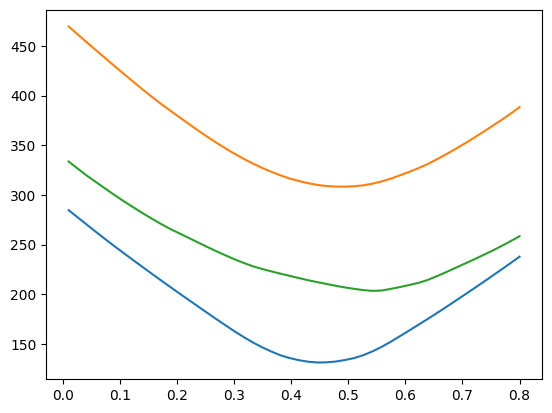

In [20]:
sub_scale_factor = np.linspace(0.01, 0.8, 50)
ddv_inner = np.zeros_like(sub_scale_factor)
ddv_mid = np.zeros_like(sub_scale_factor)
ddv_outer = np.zeros_like(sub_scale_factor)

mask_pred_sum = ((s_pred_sm > 1e-1*s_pred_sm.max()) * mask_exp.cpu().numpy()).sum(-1).sum(-1)
_mask = mask_pred_sum[1:-1,1:-1] > 0

mask_inner_sum = (mask_inner.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
mask_mid_sum = (mask_mid.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0
mask_outer_sum = (mask_outer.sum(-1).sum(-1)[1:-1, 1:-1] * _mask) > 0

for i_scale_factor, _scale_factor in tqdm(enumerate(sub_scale_factor), total=len(sub_scale_factor)):

    background = total_signal.copy()
    background[mask_inner] = total_signal[mask_inner] - _scale_factor * s_pred_masked_sm[mask_inner]
    background[mask_mid] = total_signal[mask_mid] - _scale_factor * s_pred_masked_sm[mask_mid]
    background[mask_outer] = total_signal[mask_outer] - _scale_factor * s_pred_masked_sm[mask_outer]

    background_hk = background.sum(-1).sum(-1)
    
    # background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
    # background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]
    
    background_hk_dh = background_hk[2:,1:-1] - background_hk[:-2,1:-1]
    background_hk_dk = background_hk[1:-1,2:] - background_hk[1:-1,:-2]
    
    ddv_inner[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_inner_sum].mean()
    ddv_mid[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_mid_sum].mean()
    ddv_outer[i_scale_factor] = np.abs(background_hk_dh - background_hk_dk)[mask_outer_sum].mean()
plt.plot(sub_scale_factor, ddv_inner, '-')
plt.plot(sub_scale_factor, ddv_mid, '-')
plt.plot(sub_scale_factor, ddv_outer, '-')

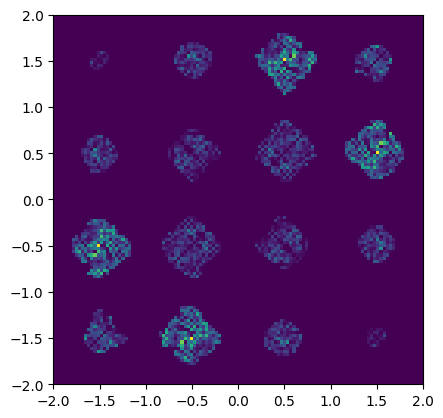

In [21]:
best_sub_inner_scale_factor = sub_scale_factor[np.argmin(ddv_inner)]
best_sub_mid_scale_factor = sub_scale_factor[np.argmin(ddv_mid)]
best_sub_outer_scale_factor = sub_scale_factor[np.argmin(ddv_outer)]
# best_sub_scale_factor = 1

background = total_signal.copy()
background[mask_inner] = total_signal[mask_inner] - best_sub_inner_scale_factor * s_pred_masked_sm[mask_inner]
background[mask_mid] = total_signal[mask_mid] - best_sub_mid_scale_factor * s_pred_masked_sm[mask_mid]
background[mask_outer] = total_signal[mask_outer] - best_sub_outer_scale_factor * s_pred_masked_sm[mask_outer]

background_hk = background.sum(-1).sum(-1)

background_hk_dh = background_hk[2:,1:-1] - 2*background_hk[1:-1,1:-1] + background_hk[:-2,1:-1]
background_hk_dk = background_hk[1:-1,2:] - 2*background_hk[1:-1,1:-1] + background_hk[1:-1,:-2]

# plt.imshow((np.abs(background_hk_dh - background_hk_dk) * _mask).T, origin='lower', extent=[-2, 2, -2, 2])

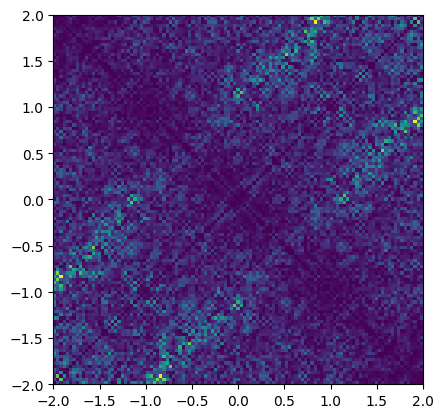

In [22]:
plt.imshow(np.abs(background_hk_dh - background_hk_dk)[2:-2,2:-2].T, origin='lower', extent=[-2, 2, -2, 2])

In [32]:
cmap = sns.color_palette("RdBu_r", as_cmap=True)

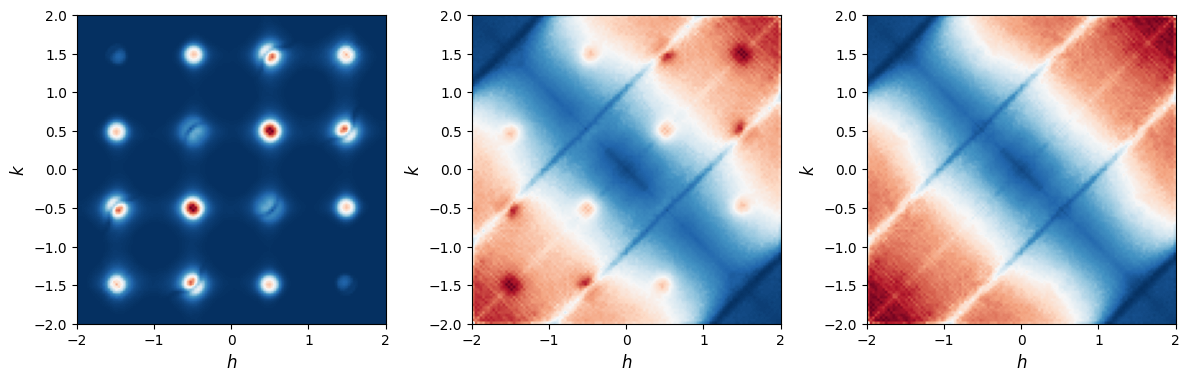

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(s_pred_masked_sm.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow((neutron_exp.Sqw.cpu().numpy().sum(-1).sum(-1)).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)


ax = axes[2]
ax.imshow(background.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

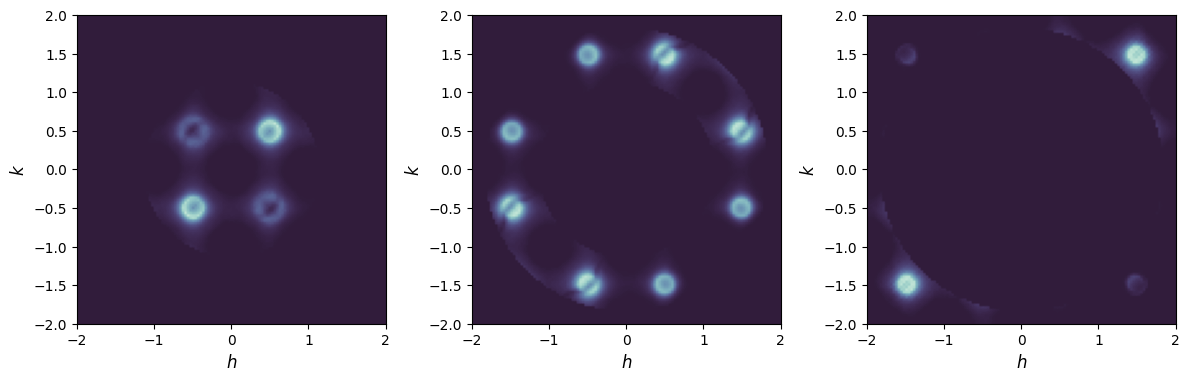

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.imshow(mask_inner.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[1]
ax.imshow(mask_mid.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

ax = axes[2]
ax.imshow(mask_outer.sum(-1).sum(-1).T, origin='lower', extent=[-2, 2, -2, 2], cmap=cmap)
ax.set_xlabel('$h$', fontsize=12)
ax.set_ylabel('$k$', fontsize=12)

fig.tight_layout()

In [26]:
data_w_bkg = {key: val for (key, val) in data.items()}

In [27]:
data_w_bkg['background'] = background

In [28]:
# torch.save(data_w_bkg, f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')